# Notebook Code Block 1: Load Dataset (same as Part 1)

In [2]:
import os
import numpy as np
from PIL import Image

def load_dataset(folder_path):
    X = []
    y = []
    for fname in os.listdir(folder_path):
        if fname.endswith('.png') or fname.endswith('.jpg'):
            path = os.path.join(folder_path, fname)
            img = Image.open(path).convert('L')
            img_array = np.array(img).flatten() / 255.0
            X.append(img_array)
            y.append(1 if 'positive' in fname.lower() else 0)
    return np.array(X), np.array(y)

# Paths (ensure these are correct for your setup)
train_path = 'data - Copy/Train'
test_path = 'data - Copy/Test'

X_train, y_train = load_dataset(train_path)
X_test, y_test = load_dataset(test_path)

print("Shape of raw pixel training features:", X_train.shape)
print("Shape of raw pixel testing features:", X_test.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of testing labels:", y_test.shape)

Shape of raw pixel training features: (400, 50176)
Shape of raw pixel testing features: (624, 50176)
Shape of training labels: (400,)
Shape of testing labels: (624,)


Results for Logistic Regression with raw pixel features:
Lambda: 0.001 | Test Accuracy: 0.6426
Lambda: 0.01 | Test Accuracy: 0.6474
Lambda: 0.1 | Test Accuracy: 0.6683
Lambda: 1 | Test Accuracy: 0.6619
Lambda: 10 | Test Accuracy: 0.6538
Lambda: 100 | Test Accuracy: 0.6522

Best Raw Pixel Model Test Accuracy: 0.6683

Best Raw Pixel Model Classification Report:
              precision    recall  f1-score   support

     Healthy       0.69      0.21      0.32       234
   Pneumonia       0.67      0.94      0.78       390

    accuracy                           0.67       624
   macro avg       0.68      0.58      0.55       624
weighted avg       0.67      0.67      0.61       624



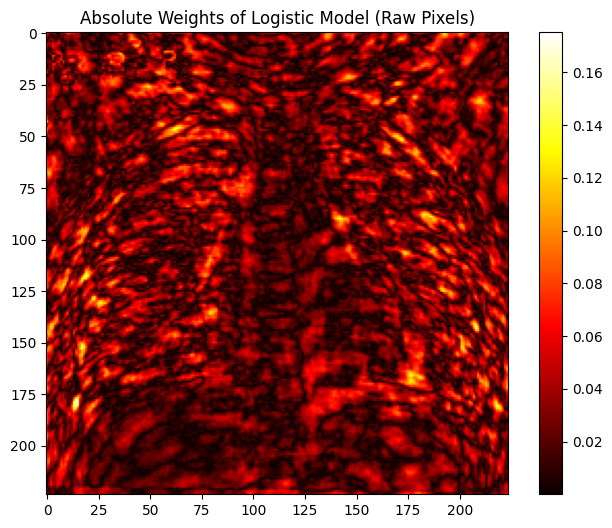

In [3]:
# Notebook Code Block 2: Train and Evaluate Logistic Regression on Raw Pixels (same as Part 1)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Try different λ values
lambdas_raw = [0.001, 0.01, 0.1, 1, 10, 100]
results_raw = []

for lam in lambdas_raw:
    model_raw = LogisticRegression(penalty='l2', C=1/lam, solver='lbfgs', max_iter=500)
    model_raw.fit(X_train, y_train)
    y_pred_raw = model_raw.predict(X_test)
    acc_raw = accuracy_score(y_test, y_pred_raw)
    results_raw.append((lam, acc_raw, model_raw))

# Show results for raw pixels
print("Results for Logistic Regression with raw pixel features:")
for lam, acc, _ in results_raw:
    print(f"Lambda: {lam} | Test Accuracy: {acc:.4f}")

# Pick the best performing model on raw pixels
best_model_raw = max(results_raw, key=lambda x: x[1])[2]

# Evaluate the best raw pixel model
y_pred_best_raw = best_model_raw.predict(X_test)
accuracy_best_raw = accuracy_score(y_test, y_pred_best_raw)
report_best_raw = classification_report(y_test, y_pred_best_raw, target_names=["Healthy", "Pneumonia"])

print(f"\nBest Raw Pixel Model Test Accuracy: {accuracy_best_raw:.4f}")
print("\nBest Raw Pixel Model Classification Report:")
print(report_best_raw)

# Visualize the learned weights for the best raw pixel model
weights_raw = best_model_raw.coef_.reshape(224, 224)

plt.figure(figsize=(8, 6))
plt.imshow(np.abs(weights_raw), cmap='hot')
plt.title('Absolute Weights of Logistic Model (Raw Pixels)')
plt.colorbar()
plt.show()

In [4]:
# Notebook Code Block 3: HOG Feature Extraction
from skimage.feature import hog

def extract_hog_features(image, patch_size=(32, 32), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys'):
    """
    Extracts HOG features from an image using local patches.

    Args:
        image (np.array): Input grayscale image (2D array).
        patch_size (tuple): Size of the non-overlapping patches.
        orientations (int): Number of orientation bins.
        pixels_per_cell (tuple): Size of a cell in pixels.
        cells_per_block (tuple): Number of cells in each block.
        block_norm (str): Block normalization method.

    Returns:
        np.array: Concatenated HOG features for the entire image.
    """
    height, width = image.shape
    patch_height, patch_width = patch_size
    hog_features_list = []

    for i in range(0, height - patch_height + 1, patch_height):
        for j in range(0, width - patch_width + 1, patch_width):
            patch = image[i:i + patch_height, j:j + patch_width]
            features = hog(patch, orientations=orientations, pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block, block_norm=block_norm, feature_vector=True)
            hog_features_list.append(features)

    return np.concatenate(hog_features_list)

# Apply HOG feature extraction to the dataset
X_train_hog = np.array([extract_hog_features(img.reshape(224, 224)) for img in X_train])
X_test_hog = np.array([extract_hog_features(img.reshape(224, 224)) for img in X_test])

print("Shape of HOG training features:", X_train_hog.shape)
print("Shape of HOG testing features:", X_test_hog.shape)

Shape of HOG training features: (400, 15876)
Shape of HOG testing features: (624, 15876)



Results for Logistic Regression with HOG features:
Lambda: 0.001 | Test Accuracy: 0.7949
Lambda: 0.01 | Test Accuracy: 0.7949
Lambda: 0.1 | Test Accuracy: 0.7901
Lambda: 1 | Test Accuracy: 0.7853
Lambda: 10 | Test Accuracy: 0.7788
Lambda: 100 | Test Accuracy: 0.7452

Best HOG Model Test Accuracy: 0.7949

Best HOG Model Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.50      0.64       234
   Pneumonia       0.76      0.97      0.86       390

    accuracy                           0.79       624
   macro avg       0.84      0.74      0.75       624
weighted avg       0.82      0.79      0.78       624



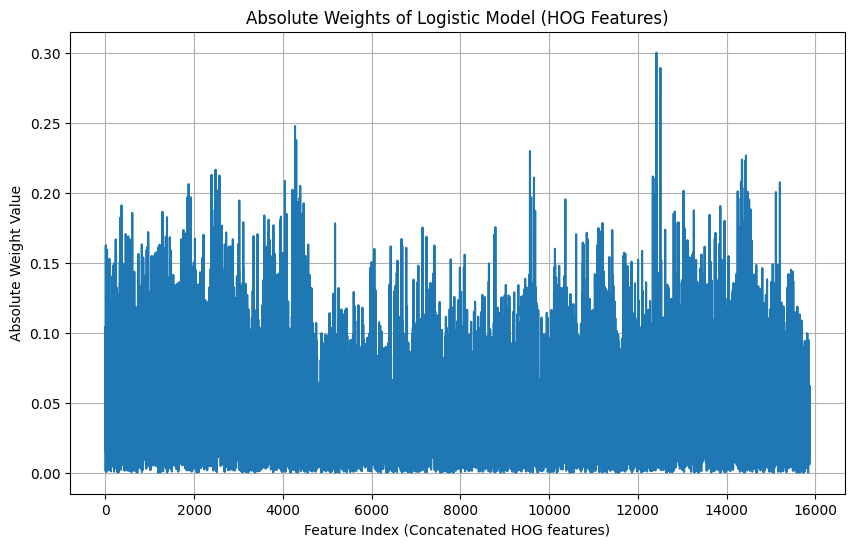

In [5]:
# Notebook Code Block 4: Train and Evaluate Logistic Regression on HOG Features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Try different λ values for HOG features
lambdas_hog = [0.001, 0.01, 0.1, 1, 10, 100]
results_hog = []

for lam in lambdas_hog:
    model_hog = LogisticRegression(penalty='l2', C=1/lam, solver='lbfgs', max_iter=500)
    model_hog.fit(X_train_hog, y_train)
    y_pred_hog = model_hog.predict(X_test_hog)
    acc_hog = accuracy_score(y_test, y_pred_hog)
    results_hog.append((lam, acc_hog, model_hog))

# Show results for HOG
print("\nResults for Logistic Regression with HOG features:")
for lam, acc, _ in results_hog:
    print(f"Lambda: {lam} | Test Accuracy: {acc:.4f}")

# Pick the best performing HOG model
best_model_hog = max(results_hog, key=lambda x: x[1])[2]

# Evaluate the best HOG model
y_pred_best_hog = best_model_hog.predict(X_test_hog)
accuracy_best_hog = accuracy_score(y_test, y_pred_best_hog)
report_best_hog = classification_report(y_test, y_pred_best_hog, target_names=["Healthy", "Pneumonia"])

print(f"\nBest HOG Model Test Accuracy: {accuracy_best_hog:.4f}")
print("\nBest HOG Model Classification Report:")
print(report_best_hog)

# Visualize the learned weights for the best HOG model
weights_hog = best_model_hog.coef_

plt.figure(figsize=(10, 6))
plt.plot(np.abs(weights_hog[0]))
plt.title('Absolute Weights of Logistic Model (HOG Features)')
plt.xlabel('Feature Index (Concatenated HOG features)')
plt.ylabel('Absolute Weight Value')
plt.grid(True)
plt.show()